## 1. Import Libraries

In [7]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.9.1+cu128
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


### Defining directories

In [8]:
base_path = Path.cwd().resolve()

datasets_path = base_path / "an2dl2526c2"
if not datasets_path.exists():
    fallback_path = base_path.parent / "an2dl2526c2"
    if fallback_path.exists():
        datasets_path = fallback_path
    else:
        raise FileNotFoundError(f"Dataset folder not found at {datasets_path} or {fallback_path}")

train_data_path = datasets_path / "train_data"
train_labels_path = datasets_path / "train_labels.csv"
test_data_path = datasets_path / "test_data"
output_path = datasets_path / "train_masked"

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")

CSV_PATH = str(train_labels_path)
SOURCE_FOLDER = str(train_data_path)
OUTPUT_FOLDER = str(output_path)
TEST_IMAGE_PATH = str(test_data_path)

Dataset path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2
Train data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data
Train labels path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_labels.csv
Test data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\test_data
Output path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_masked


### Creation of the new CSV file for the patched dataset

In [9]:
patched_output_dir = datasets_path / "filtered_patched_data"


Creating Patch-to-Label Mapping CSV

Original labels CSV contains 691 entries
Created mapping for 691 original images
Found 4819 patch files in filtered_patched_data


Mapping patches to labels: 100%|██████████| 4819/4819 [00:00<00:00, 235704.30it/s]


Mapping Results
Successfully labeled patches: 4819
Unlabeled patches: 0
Total patches: 4819

Saved patch labels to: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_labels_patched.csv

Sample of patched labels CSV:
                   filename            label
0  patch_00000_img_0000.png  Triple negative
1  patch_00001_img_0000.png  Triple negative
2  patch_00001_img_0001.png        Luminal B
3  patch_00002_img_0001.png        Luminal B
4  patch_00003_img_0001.png        Luminal B
5  patch_00004_img_0001.png        Luminal B
6  patch_00004_img_0002.png        Luminal B
7  patch_00005_img_0001.png        Luminal B
8  patch_00005_img_0002.png        Luminal B
9  patch_00006_img_0002.png        Luminal B

Label Distribution Across Patches
  HER2(+): 1311 patches (27.20%)
  Luminal A: 1497 patches (31.06%)
  Luminal B: 1540 patches (31.96%)
  Triple negative: 471 patches (9.77%)


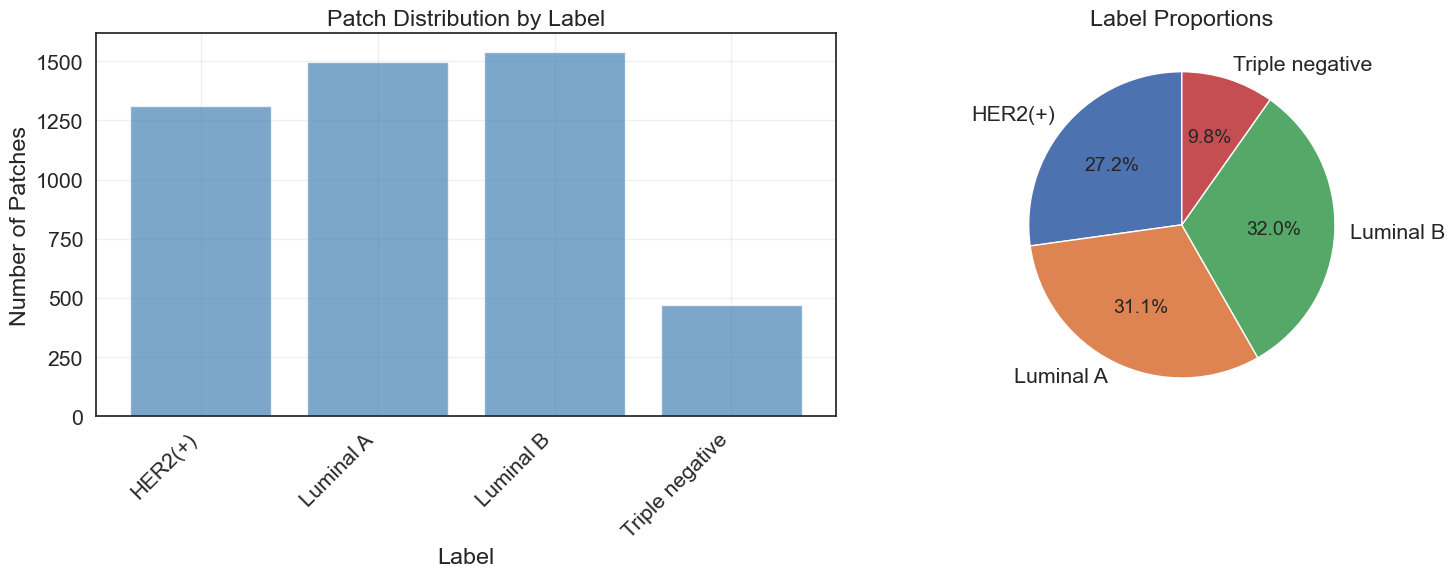

In [32]:
# Create a new CSV file mapping patches to labels based on original image indices
from typing import Counter

print(f"\n{'='*60}")
print(f"Creating Patch-to-Label Mapping CSV")
print(f"{'='*60}")

# Load original labels
original_labels_df = pd.read_csv(CSV_PATH)
print(f"\nOriginal labels CSV contains {len(original_labels_df)} entries")

# Create a mapping dictionary: image_number -> label
# The CSV format is: img_XXXX.jpg, label
image_to_label = {}
for idx, row in original_labels_df.iterrows():
    filename = row.iloc[0]  # e.g., "img_0042.jpg"
    label = row.iloc[1] 
    
    # Extract the image number from filename
    # "img_0042.jpg" -> 42
    img_number = int(filename.split('_')[1].split('.')[0])
    image_to_label[img_number] = label

print(f"Created mapping for {len(image_to_label)} original images")

# Get all patch files from the patched directory
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"Found {len(patch_files)} patch files in {patched_output_dir.name}")

# Create lists to store patch data
patch_data = []
img_numbers = []
labeled_count = 0
unlabeled_count = 0
label_distribution = Counter()

# Process each patch file
for patch_file in tqdm(patch_files, desc="Mapping patches to labels"):
    # Extract original image number from patch filename
    # Format: img_0042_patch03.png
    filename = patch_file.stem  # Remove .png -> "img_0042_patch03"
    parts = filename.split('_')
    
    filename = patch_file.stem  # e.g., "patch_00001_img_0000"
    parts = filename.split('_')

    # Expected format: ['patch', PATCH_IDX, 'img', IMG_IDX]
    if len(parts) == 4 and parts[0] == "patch" and parts[2] == "img":
        try:
            patch_idx = int(parts[1])
            original_img_number = int(parts[3])   # <-- CORRECT EXTRACTION

            if original_img_number in image_to_label:
                label = image_to_label[original_img_number]

                patch_data.append({
                    'filename': patch_file.name,
                    'label': label
                })

                img_numbers.append(original_img_number)

                labeled_count += 1
                label_distribution[label] += 1
            else:
                unlabeled_count += 1

        except ValueError:
            tqdm.write(f"Warning: could not parse numbers in {patch_file.name}")
            unlabeled_count += 1
    else:
        tqdm.write(f"Warning: unexpected filename format: {patch_file.name}")
        unlabeled_count += 1

# Create DataFrame from patch data
patches_df = pd.DataFrame(patch_data)

print(f"\n{'='*60}")
print(f"Mapping Results")
print(f"{'='*60}")
print(f"Successfully labeled patches: {labeled_count}")
print(f"Unlabeled patches: {unlabeled_count}")
print(f"Total patches: {len(patch_files)}")

if labeled_count > 0:
    # Save to new CSV file
    patches_csv_path = datasets_path / "train_labels_patched.csv"
    patches_df.to_csv(patches_csv_path, index=False)
    print(f"\nSaved patch labels to: {patches_csv_path}")
    
    # Display sample of the CSV
    print(f"\nSample of patched labels CSV:")
    print(patches_df.head(10))
    
    # Show label distribution
    print(f"\n{'='*60}")
    print(f"Label Distribution Across Patches")
    print(f"{'='*60}")
    for label, count in sorted(label_distribution.items()):
        percentage = (count / labeled_count) * 100
        print(f"  {label}: {count} patches ({percentage:.2f}%)")
    
    # Visualize label distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart
    labels_sorted = sorted(label_distribution.keys())
    counts_sorted = [label_distribution[l] for l in labels_sorted]
    
    axes[0].bar(range(len(labels_sorted)), counts_sorted, color='steelblue', alpha=0.7)
    axes[0].set_xticks(range(len(labels_sorted)))
    axes[0].set_xticklabels(labels_sorted, rotation=45, ha='right')
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Number of Patches')
    axes[0].set_title('Patch Distribution by Label')
    axes[0].grid(True, alpha=0.3)
    
    # Pie chart
    axes[1].pie(counts_sorted, labels=labels_sorted, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Label Proportions')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\nError: No patches were successfully labeled!")

### Splitting the dataset


Aligning Patched Images with Labels (Split by Original Images)

Loaded 691 original image labels from CSV
Created mapping for 691 original images
Loaded 4819 patch-label mappings

Splitting Original Images (to prevent data leakage)
Number of original images with patches: 691

Original image split:
  Training images: 483
  Validation images: 187
  Test images: 21

Assigning Patches to Splits
Found 4819 total patch files


Loading and splitting patches: 100%|██████████| 4819/4819 [00:10<00:00, 440.78it/s]



Split Results
Skipped patches: 0
Total patches loaded: 4819

Label Encoding
Number of unique classes: 4
Classes: [np.str_('HER2(+)'), np.str_('Luminal A'), np.str_('Luminal B'), np.str_('Triple negative')]

Dataset Statistics

Training set:
  Images: (3450, 224, 224, 3)
  Labels: (3450,)
  Patches per original image (avg): 7.14
  Class distribution: [ 964 1049 1107  330]

Validation set:
  Images: (1206, 224, 224, 3)
  Labels: (1206,)
  Patches per original image (avg): 6.45
  Class distribution: [311 385 379 131]

Test set:
  Images: (163, 224, 224, 3)
  Labels: (163,)
  Patches per original image (avg): 7.76
  Class distribution: [36 63 54 10]

Class Distribution Across Splits

HER2(+) (class 0):
  Train: 964 (73.5%)
  Val:   311 (23.7%)
  Test:  36 (2.7%)

Luminal A (class 1):
  Train: 1049 (70.1%)
  Val:   385 (25.7%)
  Test:  63 (4.2%)

Luminal B (class 2):
  Train: 1107 (71.9%)
  Val:   379 (24.6%)
  Test:  54 (3.5%)

Triple negative (class 3):
  Train: 330 (70.1%)
  Val:   131 

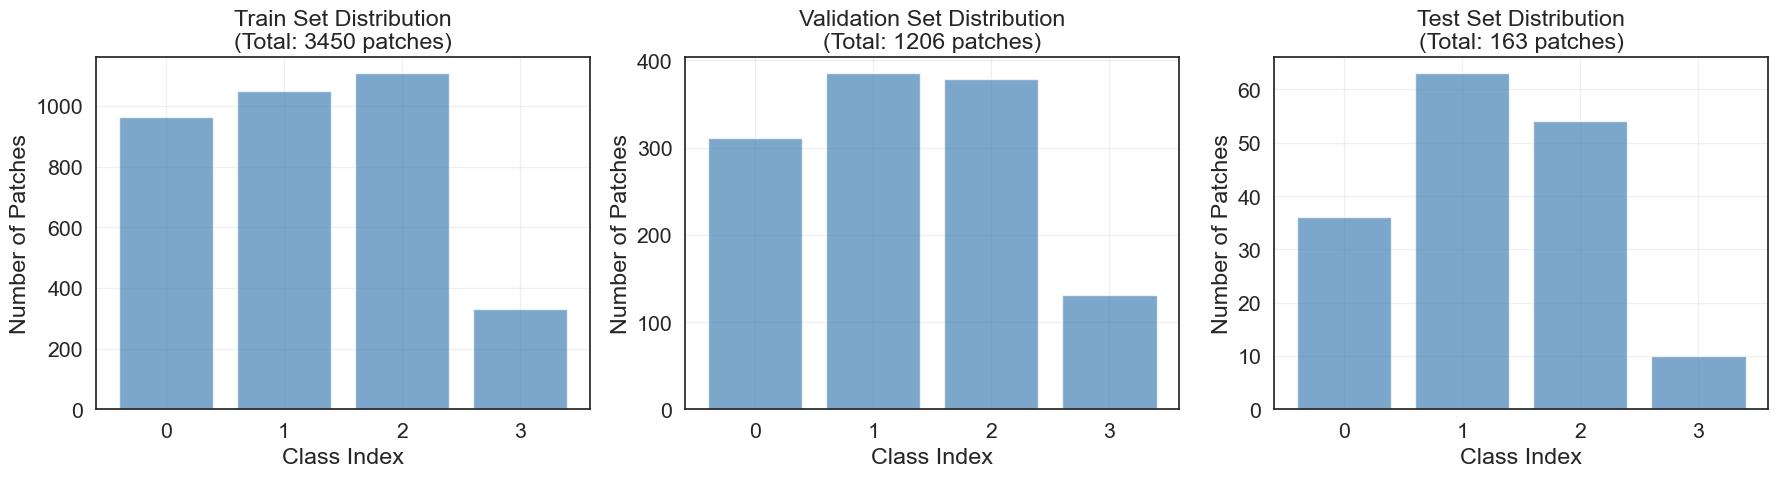


Dataset preparation complete!
No data leakage: Each original image's patches are in only ONE split


In [34]:
from sklearn.preprocessing import LabelEncoder

print(f"\n{'='*60}")
print(f"Aligning Patched Images with Labels (Split by Original Images)")
print(f"{'='*60}")

# Load the ORIGINAL labels CSV (not the patched one)
original_csv_path = datasets_path / "train_labels.csv"
if not original_csv_path.exists():
    raise FileNotFoundError(f"Original labels CSV not found at {original_csv_path}")

original_labels_df = pd.read_csv(original_csv_path)
print(f"\nLoaded {len(original_labels_df)} original image labels from CSV")

# Create mapping: image_number -> label
image_to_label = {}
for idx, row in original_labels_df.iterrows():
    filename = row.iloc[0] 
    label = row.iloc[1]      
    img_number = int(filename.split('_')[1].split('.')[0])
    image_to_label[img_number] = label

print(f"Created mapping for {len(image_to_label)} original images")

# Load the patched labels CSV to get all patches
patches_csv_path = datasets_path / "train_labels_patched.csv"
if not patches_csv_path.exists():
    raise FileNotFoundError(f"Patched labels CSV not found at {patches_csv_path}")

patches_df = pd.read_csv(patches_csv_path)
print(f"Loaded {len(patches_df)} patch-label mappings")

# STEP 1: Split at the ORIGINAL IMAGE LEVEL
print(f"\n{'='*60}")
print(f"Splitting Original Images (to prevent data leakage)")
print(f"{'='*60}")

print(f"Number of original images with patches: {len(original_img_numbers)}")

# Get labels for these images
original_labels = [image_to_label[img_num] for img_num in original_img_numbers]

# Encode labels for stratification
label_encoder = LabelEncoder()
original_labels_encoded = label_encoder.fit_transform(original_labels)

# Split original images into train/temp (80/20)
train_img_nums, temp_img_nums, train_img_labels, temp_img_labels = train_test_split(
    original_img_numbers,
    original_labels_encoded,
    test_size=0.3,
    random_state=SEED,
    stratify=original_labels_encoded
)

# Split temp into val/test (50/50 of temp = 10/10 of total)
val_img_nums, test_img_nums, val_img_labels, test_img_labels = train_test_split(
    temp_img_nums,
    temp_img_labels,
    test_size=0.1,
    random_state=SEED,
    stratify=temp_img_labels
)

print(f"\nOriginal image split:")
print(f"  Training images: {len(train_img_nums)}")
print(f"  Validation images: {len(val_img_nums)}")
print(f"  Test images: {len(test_img_nums)}")

# STEP 2: Assign patches to splits based on their original image
print(f"\n{'='*60}")
print(f"Assigning Patches to Splits")
print(f"{'='*60}")

train_img_set = set(train_img_nums)
val_img_set = set(val_img_nums)
test_img_set = set(test_img_nums)

# Get all patch files
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"Found {len(patch_files)} total patch files")

# Create a dictionary for fast lookup: filename -> label
patch_to_label = dict(zip(patches_df['filename'], patches_df['label']))

# Separate patches into train/val/test based on original image
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

skipped_count = 0

for patch_file in tqdm(patch_files, desc="Loading and splitting patches"):
    
    patch_filename = patch_file.name

    filename_no_ext = patch_filename.replace(".png", "")
    parts = filename_no_ext.split('_')

    # Expect: ['patch', PATCH_IDX, 'img', IMG_IDX]
    if len(parts) != 4 or parts[0] != "patch" or parts[2] != "img":
        skipped_count += 1
        continue

    try:
        patch_idx = int(parts[1])
        original_img_number = int(parts[3])   # <-- Correct field
    except ValueError:
        skipped_count += 1
        continue

    # Look up the label
    if patch_filename not in patch_to_label:
        skipped_count += 1
        continue
    
    label = patch_to_label[patch_filename]
    
    # Load the patch image
    patch_img = cv2.imread(str(patch_file))
    if patch_img is None:
        tqdm.write(f"Warning: Could not load {patch_filename}")
        skipped_count += 1
        continue
    
    # Convert BGR to RGB and normalize to [0, 1]
    patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB) / 255.0
    
    # Assign to appropriate split based on original image number
    if original_img_number in train_img_set:
        X_train_list.append(patch_rgb)
        y_train_list.append(label)
    elif original_img_number in val_img_set:
        X_val_list.append(patch_rgb)
        y_val_list.append(label)
    elif original_img_number in test_img_set:
        X_test_list.append(patch_rgb)
        y_test_list.append(label)
    else:
        skipped_count += 1

# Convert to numpy arrays
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

print(f"\n{'='*60}")
print(f"Split Results")
print(f"{'='*60}")
print(f"Skipped patches: {skipped_count}")
print(f"Total patches loaded: {len(X_train) + len(X_val) + len(X_test)}")

# Encode labels
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Print class mapping
print(f"\n{'='*60}")
print(f"Label Encoding")
print(f"{'='*60}")
print(f"Number of unique classes: {len(label_encoder.classes_)}")
print(f"Classes: {list(label_encoder.classes_)}")

# Show split statistics
print(f"\n{'='*60}")
print(f"Dataset Statistics")
print(f"{'='*60}")

print(f"\nTraining set:")
print(f"  Images: {X_train.shape}")
print(f"  Labels: {y_train_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_train) / len(train_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_train_encoded)}")

print(f"\nValidation set:")
print(f"  Images: {X_val.shape}")
print(f"  Labels: {y_val_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_val) / len(val_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_val_encoded)}")

print(f"\nTest set:")
print(f"  Images: {X_test.shape}")
print(f"  Labels: {y_test_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_test) / len(test_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_test_encoded)}")

# Show label distribution across splits
unique_train, counts_train = np.unique(y_train_encoded, return_counts=True)
unique_val, counts_val = np.unique(y_val_encoded, return_counts=True)
unique_test, counts_test = np.unique(y_test_encoded, return_counts=True)

print(f"\n{'='*60}")
print(f"Class Distribution Across Splits")
print(f"{'='*60}")
for class_idx in range(len(label_encoder.classes_)):
    class_name = label_encoder.classes_[class_idx]
    train_count = counts_train[class_idx] if class_idx in unique_train else 0
    val_count = counts_val[class_idx] if class_idx in unique_val else 0
    test_count = counts_test[class_idx] if class_idx in unique_test else 0
    total = train_count + val_count + test_count
    
    print(f"\n{class_name} (class {class_idx}):")
    print(f"  Train: {train_count} ({train_count/total*100:.1f}%)")
    print(f"  Val:   {val_count} ({val_count/total*100:.1f}%)")
    print(f"  Test:  {test_count} ({test_count/total*100:.1f}%)")

# Visualize split distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, split_labels) in enumerate([
    ('Train', y_train_encoded), 
    ('Validation', y_val_encoded), 
    ('Test', y_test_encoded)
]):
    class_counts = np.bincount(split_labels)
    axes[idx].bar(range(len(class_counts)), class_counts, color='steelblue', alpha=0.7)
    axes[idx].set_xlabel('Class Index')
    axes[idx].set_ylabel('Number of Patches')
    axes[idx].set_title(f'{split_name} Set Distribution\n(Total: {len(split_labels)} patches)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Update the global variables to use encoded labels
y_train = y_train_encoded
y_val = y_val_encoded
y_test = y_test_encoded

print(f"\n{'='*60}")
print(f"Dataset preparation complete!")
print(f"No data leakage: Each original image's patches are in only ONE split")
print(f"{'='*60}")

In [35]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


### Converting the data into Pytorch dataset

In [36]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds = TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2),
    torch.from_numpy(y_train).squeeze().long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2),
    torch.from_numpy(y_val).squeeze().long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2),
    torch.from_numpy(y_test).squeeze().long()
)

In [37]:
# Define the batch size
BATCH_SIZE = 32

### **Dataset class**

In [38]:
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class TissueDataset(torch.utils.data.Dataset):
    """Custom PyTorch Dataset with augmentation and normalization."""

    def __init__(self, data, labels, augmentation=None, normalize_imagenet=False):
        """
        Args:
            data: numpy array of images (N, H, W, C) in range [0, 1]
            labels: numpy array of labels
            augmentation: transforms for data augmentation
            normalize_imagenet: whether to apply ImageNet normalization
        """
        # Convert from (N, H, W, C) to (N, C, H, W) for PyTorch
        # IMPORTANT: Use .float() to ensure float32 type (compatible with mixed precision)
        self.data = torch.from_numpy(data).permute(0, 3, 1, 2).float()
        self.labels = torch.from_numpy(labels).long()
        self.augmentation = augmentation
        self.normalize_imagenet = normalize_imagenet

        # ImageNet normalization transform
        if normalize_imagenet:
            self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        else:
            self.normalize = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].clone()  # Clone to avoid modifying original (already in C, H, W format)
        label = self.labels[idx]

        # Apply augmentation if provided (on images in [0, 1] range)
        if self.augmentation:
            image = self.augmentation(image)
            # CRITICAL FIX: Clip values back to [0, 1] after augmentation
            # TrivialAugmentWide and other augmentations can push values outside [0, 1]
            image = torch.clamp(image, 0.0, 1.0)

        # Apply ImageNet normalization if requested
        if self.normalize:
            image = self.normalize(image)

        return image, label

### **Helper data loading function**

In [39]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Use 0 workers on Windows to avoid multiprocessing issues
    # Single-threaded loading is more stable on Windows
    num_workers = 0

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
    )

### **Network parameters**

In [40]:
# Training parameters
# FIXED: Reduced learning rate for better convergence from scratch
LEARNING_RATE = 1e-4  # Changed from 3e-4 (too high for from-scratch training)
EPOCHS = 200
PATIENCE = 50

# Regularization
# FIXED: Reduced dropout for early training
DROPOUT_RATE = 0.2  # Changed from 0.3 (less aggressive)
L2_REGULARIZATION = 1e-4  # Reduced from 1e-3

from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
weight_tensor = torch.tensor(weights, dtype=torch.float32, device=device)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        if self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

criterion = FocalLoss(weight=weight_tensor, gamma=2.0)

# Print the defined parameters
print(" UPDATED TRAINING PARAMETERS:")
print("="*60)
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE, "← Reduced for better convergence")
print("Dropout Rate:", DROPOUT_RATE, "← Less aggressive")
print("L2 Regularization:", L2_REGULARIZATION, "← Reduced")
print("Patience:", PATIENCE)
print("="*60)

 UPDATED TRAINING PARAMETERS:
Epochs: 200
Batch Size: 32
Learning Rate: 0.0001 ← Reduced for better convergence
Dropout Rate: 0.2 ← Less aggressive
L2 Regularization: 0.0001 ← Reduced
Patience: 50


### **Training functions**

In [41]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [42]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        use_amp = device.type == 'cuda' and scaler is not None
        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling (only if scaler is provided)
        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    all_targets_concat = np.concatenate(all_targets)
    all_predictions_concat = np.concatenate(all_predictions)
    
    epoch_f1 = f1_score(all_targets_concat, all_predictions_concat, average='weighted')
    epoch_precision = precision_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)

    return epoch_loss, epoch_f1, epoch_precision, epoch_recall

In [43]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    all_targets_concat = np.concatenate(all_targets)
    all_predictions_concat = np.concatenate(all_predictions)
    
    epoch_f1 = f1_score(all_targets_concat, all_predictions_concat, average='weighted')
    epoch_precision = precision_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)

    return epoch_loss, epoch_f1, epoch_precision, epoch_recall

In [44]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", scheduler=None):
    """
    Train the neural network model on the training data and validate on the validation data.

# NOTE: Graphviz visualization commented out - requires Graphviz installation



# model_graph.visual_graph# model_graph = draw_graph(scratch_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)# After installing Graphviz, restart kernel and uncomment these lines:        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_f1, train_precision, train_recall = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        val_loss, val_f1, val_precision, val_recall = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_f1)  # For backward compatibility
        training_history['val_acc'].append(val_f1)  # For backward compatibility
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)
        training_history['train_precision'].append(train_precision)
        training_history['val_precision'].append(val_precision)
        training_history['train_recall'].append(train_recall)
        training_history['val_recall'].append(val_recall)

        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('F1/Training', train_f1, epoch)
            writer.add_scalar('F1/Validation', val_f1, epoch)
            writer.add_scalar('Precision/Training', train_precision, epoch)
            writer.add_scalar('Precision/Validation', val_precision, epoch)
            writer.add_scalar('Recall/Training', train_recall, epoch)
            writer.add_scalar('Recall/Validation', val_recall, epoch)

        if verbose and epoch % verbose == 0:
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f}, Prec={train_precision:.4f}, Rec={train_recall:.4f} | "
                  f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}, Prec={val_precision:.4f}, Rec={val_recall:.4f}")

        # Learning rate scheduling
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_f1)  # Step based on validation F1
            else:
                scheduler.step()  # For other schedulers

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                model_path = f"models/{experiment_name}_best_model.pt"
                torch.save(model.state_dict(), model_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break
                    
    if restore_best_weights and patience > 0:
        model_path = f"models/{experiment_name}_best_model.pt"
        model.load_state_dict(torch.load(model_path))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
    return model, training_history

### **Load the dataset**

In [45]:
# Create datasets with strong augmentation for from-scratch training
train_scratch_ds = TissueDataset(X_train, y_train, augmentation=None, normalize_imagenet=False)
val_scratch_ds = TissueDataset(X_val, y_val, augmentation=None, normalize_imagenet=False)

train_scratch_loader = make_loader(train_scratch_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_scratch_loader = make_loader(val_scratch_ds, BATCH_SIZE, shuffle=False, drop_last=False)

# **Transformer implementation**

### **Conditional generator**

In [ ]:
import torch.nn as nn

class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, down=True, use_dropout=False):
        super().__init__()
        if down:
            layers = [
                nn.Conv2d(in_ch, out_ch, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.2, inplace=True),
            ]
        else:
            layers = [
                nn.ConvTranspose2d(in_ch, out_ch, 2, 2, 1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            ]
            if use_dropout:
                layers.append(nn.Dropout(0.5))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class UNetGenerator(nn.Module):
    """
    Input:  mask (1 x 224 x 224)
    Output: image (3 x 224 x 224)
    """
    def __init__(self, in_ch=1, out_ch=3, features=64):
        super().__init__()

        # Encoder
        self.down1 = UNetBlock(in_ch, features, down=True)             # 1→64
        self.down2 = UNetBlock(features, features*2, down=True)        # 64→128
        self.down3 = UNetBlock(features*2, features*4, down=True)      # 128→256
        self.down4 = UNetBlock(features*4, features*8, down=True)      # 256→512
        self.down5 = UNetBlock(features*8, features*8, down=True)      # 512→512
        self.down6 = UNetBlock(features*8, features*8, down=True)      # 512→512

        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, bias=False),
            nn.ReLU(True),
        )

        # Decoder (with skip connections)
        self.up1 = UNetBlock(features*8, features*8, down=False, use_dropout=True)
        self.up2 = UNetBlock(features*8*2, features*8, down=False, use_dropout=True)
        self.up3 = UNetBlock(features*8*2, features*8, down=False, use_dropout=True)
        self.up4 = UNetBlock(features*8*2, features*4, down=False)
        self.up5 = UNetBlock(features*4*2, features*2, down=False)
        self.up6 = UNetBlock(features*2*2, features, down=False)

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, out_ch, 4, 2, 1),
            nn.Tanh(),   # output in [-1,1]
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)  # (64)
        d2 = self.down2(d1) # (128)
        d3 = self.down3(d2) # (256)
        d4 = self.down4(d3) # (512)
        d5 = self.down5(d4) # (512)
        d6 = self.down6(d5) # (512)

        bott = self.bottleneck(d6)

        # Decoder with skip connections
        u1 = self.up1(bott)
        u1 = torch.cat([u1, d6], dim=1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d5], dim=1)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, d4], dim=1)
        u4 = self.up4(u3)
        u4 = torch.cat([u4, d3], dim=1)
        u5 = self.up5(u4)
        u5 = torch.cat([u5, d2], dim=1)
        u6 = self.up6(u5)
        u6 = torch.cat([u6, d1], dim=1)

        out = self.final_up(u6)
        return out

### **Conditional descriminator**

In [47]:
class PatchDiscriminator(nn.Module):
    """
    Input: concatenated [mask, image] => (1+3, H, W)
    Output: patch-wise real/fake map (N x 1 x H' x W')
    """
    def __init__(self, in_ch=1+3, features=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, features, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features*2, features*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features*4, features*8, 4, 1, 1, bias=False),
            nn.BatchNorm2d(features*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features*8, 1, 4, 1, 1)  # no sigmoid here (use BCEWithLogits)
        )

    def forward(self, mask, img):
        x = torch.cat([mask, img], dim=1)
        return self.net(x)


### **Load transformers model**

In [ ]:
# ===============================================
#  DEVICE & MODELS
# ===============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_generator = UNetGenerator().to(device)
patch_discriminator = PatchDiscriminator().to(device)

print(f"\n{'='*60}")
print(f"UNet Generator and Patch Discriminator Models")
print(f"{'='*60}")
print(f"UNet Generator:\n{unet_generator}\n")
print(f"Patch Discriminator:\n{patch_discriminator}\n")


# ===============================================
#  OPTIMIZERS (GAN requires TWO separate optimizers)
# ===============================================
LEARNING_RATE = 2e-4
L2_REGULARIZATION = 1e-4

optimizer_G = torch.optim.AdamW(
    unet_generator.parameters(),
    lr=LEARNING_RATE,
    weight_decay=L2_REGULARIZATION,
    betas=(0.5, 0.999)   # recommended for GAN stability
)

optimizer_D = torch.optim.AdamW(
    patch_discriminator.parameters(),
    lr=LEARNING_RATE,
    weight_decay=L2_REGULARIZATION,
    betas=(0.5, 0.999)
)

# ===============================================
#  SCHEDULERS (optional but useful)
#  Generator and Discriminator have separate schedules
# ===============================================
EPOCHS = 100

scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_G,
    T_max=EPOCHS,
    eta_min=1e-6
)

scheduler_D = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_D,
    T_max=EPOCHS,
    eta_min=1e-6
)

# ===============================================
#  MIXED PRECISION TRAINING
# ===============================================
scaler = torch.amp.GradScaler(device.type) if torch.cuda.is_available() else None

# ===============================================
#  TENSORBOARD LOGGER
# ===============================================
from torch.utils.tensorboard import SummaryWriter

experiment_name = "GAN_training_UNetGenerator_PatchDiscriminator"
writer = SummaryWriter(log_dir=f"tensorboard/{experiment_name}")

print("\nFIXED GAN TRAINING SETUP:")
print("="*60)
print(f"  Optimizers: AdamW for both Generator and Discriminator")
print(f"  Scheduler:  CosineAnnealingLR for both models")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Generator Model: UNetGenerator")
print(f"  Discriminator Model: PatchDiscriminator")
print(f"  Mixed Precision: {'Enabled' if scaler else 'Disabled'}")
print("="*60)

In [ ]:
input_shape_U = (1, 224, 224)

# summary(unet_generator, input_size=input_shape_U)

### **Training GAN model**

In [ ]:
def train_gan(unet_generator, patch_discriminator, dataloader, epochs, device):

    g_opt = torch.optim.Adam(unet_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    d_opt = torch.optim.Adam(patch_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

    adversarial_loss = nn.BCEWithLogitsLoss()
    l1_loss = nn.L1Loss()

    for epoch in range(epochs):
        for mask, real_img in dataloader:

            mask = mask.to(device)
            real_img = real_img.to(device)

            # ----------------------------
            # 1. Train Discriminator
            # ----------------------------
            fake_img = unet_generator(mask).detach()

            d_opt.zero_grad()

            real_pred = patch_discriminator(mask, real_img)
            fake_pred = patch_discriminator(mask, fake_img)

            real_labels = torch.ones_like(real_pred)
            fake_labels = torch.zeros_like(fake_pred)

            d_loss = (adversarial_loss(real_pred, real_labels) +
                      adversarial_loss(fake_pred, fake_labels)) * 0.5

            d_loss.backward()
            d_opt.step()

            # ----------------------------
            # 2. Train Generator
            # ----------------------------
            fake_img = unet_generator(mask)
            pred_fake = patch_discriminator(mask, fake_img)

            g_opt.zero_grad()

            adv_loss = adversarial_loss(pred_fake, real_labels)
            l1 = l1_loss(fake_img, real_img) * 100

            g_loss = adv_loss + l1

            g_loss.backward()
            g_opt.step()

        print(f"Epoch {epoch+1}/{epochs} | G_loss: {g_loss.item():.3f} | D_loss: {d_loss.item():.3f}")
